In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
n_epochs = 3 #全部数据的迭代次数（整个卷积要轮回的次数）
batch_size_train = 64 #每次训练所抓取用于权重更新的数据样的数量
batch_size_test = 1000#测试集规模
learning_rate = 0.01

momentum = 0.5
log_interval = 10 #控制可视化输出间隔

random_seed = 1
torch.manual_seed(random_seed)
#是否使用非确定性算法，True时会自动寻找适合当前的高效算法。
torch.backends.cudnn.enabled = False 

torchvision.transforms.Compose()类：串联多个图片变换的操作

torchvision.transforms.ToTensor()：将图像PIL.Image或ndarray从 (H x W x C)形状转换为 (C x H x W) 的tensor。

[h, w, c]：数组中最外层即hight，表示图像像素有几行；第二层元素width，表示图像像素几列，最后一层元素为每一个通道的数值。

[c, h, w]：数组中第一层元素为图像有一个通道，第二层元素为某个通道上的一行像素，第三层为该通道上某列的像素值。

transforms.Normalize(mean, std) 的计算公式：
input[channel] = (input[channel] - mean[channel]) / std[channel]

enumerate():将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标

### 导入训练集和测试集，转换为tensor并归一化、分成一个个batch

In [3]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('./data/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('./data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


#### 获取一个batch：（样本数量，通道，32,32维）

In [4]:
examples = enumerate(train_loader)
#将训练集train_loader遍历并组合为一个索引序列，同时列出数据和数据标签

#next(iterable[, default])： 返回迭代器的下一个项目
batch_idx, (example_data, example_targets) = next(examples)
#print(example_targets)
print(example_data.shape)#一个batch有64张黑白像素28*28图

torch.Size([64, 3, 32, 32])


In [5]:
class_names =["Airplane","Automobile","Bird","Cat",
               "Deer","Dog","Frog","Horse","Ship","Truck"]

### 展示训练集示例及其label

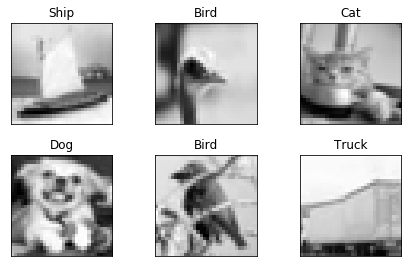

In [6]:
fig = plt.figure()
for i in range(6):
    """展示训练集中前6个图像的灰度图像"""
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray',interpolation='none')
#     plt.title(" {}".format(example_targets[i]))
    plt.title(class_names[example_targets[i]], fontsize=12)
    plt.xticks([])
    plt.yticks([])
plt.show()

### 搭建网络

nn.Conv2d(in_channels,out_channels,kernel_size,stride = 1,padding = 0,dilation = 1,
groups = 1,bias = True,padding_mode = 'zeros')

in_channels:输入的四维张量[N, C, H, W]中的C了，即输入张量的channels数

out_channels:期望的四维输出张量的channels数

kernel_size:卷积核的大小

stride = 1：默认为1，卷积核在图像窗口上每次平移的间隔，即所谓的步长

Padding：图像填充，后面的int型常数代表填充的多少（行数、列数），默认为0

groups = 1：决定了是否采用分组卷积

padding_mode = ‘zeros’：即padding的模式，默认采用零填充。

#### 卷积后得到的图像Dimension=(输入维度−卷积核维度)/步长+1

#### view（）：相当于reshape（）。
其中参数定为-1时代表自动调整这个维度上的元素个数，以保证元素的总数不变。

In [7]:
class Net(nn.Module):
    def __init__(self):
        """初始化定义模型结构,需要维度相对应"""
        super(Net, self).__init__()
        #输入为（batch_size,3,32,32）,设batch_size为n
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        #二维卷积层,卷积核大小5*5，
        #3表述输入的数据通道是3,10表示输出的通道是10
        #使用10个卷积核就可以得到10 × 10 × 10的卷积层，10=（32-5）/3+1
        
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        #使用20个卷积核就可以得到10 × 10 × 20的卷积层，10=（32-5）/3+1
        
        self.conv2_drop = nn.Dropout2d()#Dropout层，随机扔掉一些神经元
        
        self.fc1 = nn.Linear(320, 50)#全连接层
        self.fc2 = nn.Linear(50, 10)
 
    def forward(self, x):
        """forward向前推进：定义每一层的输入和输出
        F.relu():函数调用"""
    
        x = F.relu(F.max_pool2d(self.conv1(x), 2))#使用最大池化层，窗口2*2，步长2
        #内部conv1输出（n,10,24,24）
        #得到池化后的卷积层为12 × 12 × 10，12=(24-2)/2+1，x为（n,10,12,12）。
        
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #内部conv2输出（64,20，8,8），8=（12-5）/1+1
        #得到池化后的卷积层为4×4×20，4=(8-2)/2+1，x为（n,20,4,4）。
        
        x = x.view(-1, 320)#重新定义矩阵的形状，将数据变成320维的数据即(n,320)
        
        x = F.relu(self.fc1(x))#通过全连接层1后的输出，x为（n,50）
        x = F.dropout(x, training=self.training)
        
        x = self.fc2(x)#输出10维，x为（n,10），10个类中属于每个类的概率
        return F.log_softmax(x, dim=1)
    #在softmax函数的基础上，再进行一次log运算，dim=1保证10个类的概率相加和为1

#### 实例化网络

In [8]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)#加入动量的随机梯度下降

In [9]:
"""定义用于存储数据的容器"""
train_losses = []
train_counter = []#训练损失定义的时间点
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

### 定义训练过程

#### network.state_dict()：保存中间的训练状态，保存后以后可从任何一步开始重新训练网络

In [10]:
#### log_softmax是指在softmax函数的基础上，再进行一次log运算
#### nn.NLLLoss():输入是一个对数概率向量和一个目标标签,计算交叉熵

In [11]:
#enumerate(train_loader)将训练集遍历并组合为一个索引序列，列出数据和数据下标
#F是torch.nn.functional
def train(epoch):
    network.train()#对每个epoch调用Net类中继承nn.Module的train方法
    
    #batch_idx为batch的索引序号
    for batch_idx, (data, target) in enumerate(train_loader):
        """对每个batch执行的操作"""
        
        optimizer.zero_grad()#把优化器的所有梯度0初始化
        #若不清0会与上一个batch相关，但实际每个batch并不需要有关联
        
        output = network(data)#把训练集中的数据导入网络
        
        loss = F.nll_loss(output, target)#计算梯度：模型输出结果与真实标签的误差
        loss.backward()#反向回传
        
        optimizer.step()#进行单次优化，更新batch中的所有参数
        
        #结果输出
        print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                batch_idx * len(data),len(train_loader.dataset),
                100. * batch_idx / len(train_loader),loss.item()),
                end=" " )
        train_losses.append(loss.item())
        #train_counter记录已训练的数据的个数
        train_counter.append((batch_idx * 64) + 
                             ((epoch - 1) * len(train_loader.dataset)))
        
        #保存模型中间状态，保存后可从任何一步开始重新训练网络
        torch.save(network.state_dict(), './model.pth')#保留中间过程
        torch.save(optimizer.state_dict(), './optimizer.pth')

In [12]:
train(1)#指定用一个epoch训练全部数据

ValueError: Expected input batch_size (100) to match target batch_size (64).

### 定义测试过程

#### .data.max(1,keepdim=True)[1]中的第一个1表示，按照行来找，找每行的最大值；
     [1]表示会返回一个数组，values既c数组中每行最大值，indices是最大值的位置
     keepdim=True维持输出的维度

#### view_as（）：返回与给定的tensor大小同形状不同的tensor，只能用于内存中连续存储的张量上。一般用于比较时确保两个比较的数据维度是一致的

In [ ]:
def test():
    network.eval()#评价，对每个epoch调用Net类中继承nn.Module的eval方法
    test_loss = 0
    correct = 0
    with torch.no_grad():#测试不需回传参数
        for data, target in test_loader:
            
            output = network(data)
            #计算损失总和
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            
            #计算准确数
            #把target的大小转换为和pred相同的大小
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\r\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)),end=" ")

In [ ]:
test()  # 不加这个，后面画图就会报错：x and y must be the same size
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

### 结果可视化

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

### 展示测试集示例及其预测类

In [ ]:
examples = enumerate(test_loader)
#将test_loader遍历并组合为一个索引序列，同时列出数据和数据下标
batch_idx, (example_data, example_targets) = next(examples)
#next(iterable[, default])： 返回迭代器的下一个项目

with torch.no_grad():
    output = network(example_data)
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()

### 从记录点开始训练数据

In [ ]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
 
network_state_dict = torch.load('model.pth')
continued_network.load_state_dict(network_state_dict)
optimizer_state_dict = torch.load('optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)
 
# 因为n_epochs=3，上面用了[1, n_epochs + 1)，所以是“4”开始
for i in range(4, 9):
    test_counter.append(i*len(train_loader.dataset))
    train(i)
    test()

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')